### COLAB SETUP

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import zipfile
import os

def verify_unzip_file(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for file_name in zip_ref.namelist():
            if file_name.startswith('__MACOSX'):
                continue
            file_path = os.path.join(extract_to, file_name)
            if not os.path.exists(file_path):
                zip_ref.extract(file_name, extract_to)
                print(f"Extracted: {file_name}")
            # else:
            #     print(f"Skipped (already exists): {file_name}")

zip_path = "drive/MyDrive/deepship_5k_seg_3s.zip"
extract_to = "data"

if not os.path.exists(extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

verify_unzip_file(zip_path, extract_to)

### Imports and utils

In [3]:
!pip install datasets

In [69]:
import time

import torch
from transformers import ASTFeatureExtractor, ASTForAudioClassification
from torch.utils.data import DataLoader, random_split, Subset
from datasets import load_dataset, Audio, ClassLabel

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
from tqdm import tqdm

In [5]:
### CONSTANTS ###

DEEPSHIP_SAMPLING_RATE = 5000
AST_SAMPLING_RATE = 16000
DEEPSHIP_ROOT_DIR = 'data'

LEARNING_RATE = 1e-5
NUM_EPOCHS = 5
BATCH_SIZE = 32

In [6]:
# Check PyTorch is using GPU
def check_gpu_use():
    if not torch.cuda.is_available():
        raise Exception('*** GPU NOT IN USE ***')
    else:
        print(f'GPU detected: {torch.cuda.get_device_name(0)}')

    return "cuda" if torch.cuda.is_available() else "cpu"

DEVICE = check_gpu_use()

GPU detected: NVIDIA A100-SXM4-40GB


In [7]:
!set USE_FLASH_ATTENTION=1
print("Device name:", torch.cuda.get_device_properties('cuda').name)
print("FlashAttention available:", torch.backends.cuda.flash_sdp_enabled())
print(f'torch version: {torch.__version__}')

Device name: NVIDIA A100-SXM4-40GB
FlashAttention available: True
torch version: 2.5.1+cu121


In [8]:
def format_time(duration):
    minutes, seconds = divmod(duration, 60)
    return f"{int(minutes)}min {seconds:.1f}sec"

### Load and preprocess data

#### Set up DeepShip as a complete PyTorch dataset

In [9]:
deepship = load_dataset("audiofolder", data_dir=DEEPSHIP_ROOT_DIR)

Resolving data files:   0%|          | 0/53502 [00:00<?, ?it/s]

In [10]:
deepship = deepship.cast_column("audio", Audio(sampling_rate=AST_SAMPLING_RATE)) # Resample to 16 kHz to be compatible with AST
deepship = deepship.cast_column("label", ClassLabel(names=['Tanker', 'Cargo', 'Tug', 'Passengership']))

print(deepship)

DatasetDict({
    train: Dataset({
        features: ['audio', 'label'],
        num_rows: 53502
    })
})


In [11]:
### Get the spectrograms ###

pretrained_model_url = "MIT/ast-finetuned-audioset-10-10-0.4593"
ast_feature_extractor = ASTFeatureExtractor.from_pretrained(pretrained_model_url)

# Process the inputs in batches
def preprocess_batch(batch):
    wavs = [audio["array"] for audio in batch["audio"]]
    inputs = ast_feature_extractor(wavs, sampling_rate=AST_SAMPLING_RATE, return_tensors="pt") # Converts to spectrograms
    batch["spectrogram"] = inputs["input_values"]
    return batch

deepship.set_transform(preprocess_batch, output_all_columns=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


#### Split the dataset into folds

At this stage, `deepship` is fully ready to be used as input to a training loop. However, to create a test-train split we will convert it into folds.

In [12]:
# RENAME FOLD DEFINITION CSV FILE PATHS

unix = True

fold_definitions = pd.read_csv("deepship_5k_seg_3s.csv")

# Points to the folder that contains the class subfolders in the csv file.
prev_path_to_root = fold_definitions.iloc[0, 0].split("Passengership")[0]

print(prev_path_to_root)

fold_definitions['files'] = fold_definitions['files'].apply(
    lambda x: x.lstrip(prev_path_to_root)
)

# x86 directory formatting
if not unix:
    fold_definitions['files'] = fold_definitions['files'].apply(
        lambda x: x.replace('/', '\\')
    )

# Convert .wav to .csv or .npz
fold_definitions['files'] = fold_definitions['files'].apply(
    lambda x: x.replace('.wav', '.mat')
)

fold_definitions.head()

/home/thales/src/ajaac/datasets/DeepShip/DeepShip_5k_seg_3s/


,files,labels,folds
0,Passengership/QUADRA_QUEEN-69-20180630_seg058.mat,3,7
1,Passengership/QUEEN_OF-60-20161102_seg003.mat,3,5
2,Passengership/NORTHERN_EXPEDITION-69-20170617_...,3,4
3,Passengership/V2V_EMPRESS-60-20180722_seg177.mat,3,0
4,Passengership/TACHEK-69-20160616_seg121.mat,3,4


In [13]:
# Dictionary which goes from FILE_PATH to FOLD_INDEX
file_to_fold = dict(zip(fold_definitions['files'], fold_definitions['folds']))

i = 0
for key, val in file_to_fold.items():
    print(key, val)
    i += 1
    if i == 5: break

Passengership/QUADRA_QUEEN-69-20180630_seg058.mat 7
Passengership/QUEEN_OF-60-20161102_seg003.mat 5
Passengership/NORTHERN_EXPEDITION-69-20170617_seg450.mat 4
Passengership/V2V_EMPRESS-60-20180722_seg177.mat 0
Passengership/TACHEK-69-20160616_seg121.mat 4


In [14]:
# Get a list of all file_paths (in order) from deepship["train"]
file_paths = [
    data['audio']['path'].split('data/')[-1].replace(".wav", ".mat")
    for data in deepship['train']
]

# Map each file path to its index in `deepship["train"]`
file_index_map = {file_path: idx for idx, file_path in enumerate(file_paths)}

# Dictionary which goes from FOLD_INDEX to [INDEX_OF_FILE_IN_DATASET]
fold_indices = {i: [] for i in range(10)}
for file_path, fold in file_to_fold.items():
    if file_path in file_index_map:
        fold_indices[fold].append(file_index_map[file_path])

In [15]:
# Map folds to splits
train_folds = list(range(2, 9))  # Folds 2 to 8
val_fold = [9]                   # Fold 9
test_folds = [0, 1]              # Folds 0 and 1

train_indices = sum([fold_indices[f] for f in train_folds], [])
val_indices = fold_indices[val_fold[0]]
test_indices = sum([fold_indices[f] for f in test_folds], [])

In [16]:
# Create subsets for each split
train_set = Subset(deepship["train"], train_indices)
val_set = Subset(deepship["train"], val_indices)
test_set = Subset(deepship["train"], test_indices)

train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_set, batch_size=BATCH_SIZE)

In [17]:
print(len(train_indices))
print(len(val_indices))
print(len(test_indices))

print(len(train_set))
print(len(val_set))
print(len(test_set))

39944
3526
10032
39944
3526
10032


### Get and edit model

In [18]:
model = ASTForAudioClassification.from_pretrained(pretrained_model_url)
model.classifier.dense = torch.nn.Linear(in_features=768, out_features=4, bias=True)
model.to(DEVICE)

ASTForAudioClassification(
  (audio_spectrogram_transformer): ASTModel(
    (embeddings): ASTEmbeddings(
      (patch_embeddings): ASTPatchEmbeddings(
        (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ASTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ASTLayer(
          (attention): ASTSdpaAttention(
            (attention): ASTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ASTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ASTIntermediate(
       

### TRAIN AST

In [19]:
train_acc_ls, val_acc_ls, train_loss_ls, val_loss_ls = [], [], [], []

def train_epoch(network, loss_fn, optimiser, epoch, train_dataloader):
    print(f"======= Starting Epoch {epoch + 1} =======")
    network.train()
    correct = 0
    running_loss = 0.0
    total = 0

    start_time = time.perf_counter()

    for batch in tqdm(train_dataloader):
        features = batch["spectrogram"].to(DEVICE)
        labels = batch["label"].to(DEVICE)

        optimiser.zero_grad()

        # Forward pass
        outputs = network(input_values=features)

        # Calculate loss and backpropagate
        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        optimiser.step()

        running_loss += loss.item() * features.size(0)
        preds = torch.argmax(outputs.logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_accuracy = (correct / total) * 100
    epoch_loss = running_loss / total
    train_acc_ls.append(epoch_accuracy)
    train_loss_ls.append(epoch_loss)

    elapsed_time = time.perf_counter() - start_time

    print(f"[{epoch + 1}] Time: {format_time(elapsed_time)}, Accuracy: {epoch_accuracy:.3f}%, Loss: {epoch_loss:.3f}")

    return epoch_accuracy, epoch_loss

def evaluate(network, loss_fn, val_dataloader):
    network.eval()
    correct = 0
    running_loss = 0.0
    total = 0

    with torch.no_grad():
        for batch in tqdm(val_dataloader):
            features = batch["spectrogram"].to(DEVICE)
            labels = batch["label"].to(DEVICE)

            outputs = network(input_values=features)

            loss = loss_fn(outputs.logits, labels)
            running_loss += loss.item() * features.size(0)

            preds = torch.argmax(outputs.logits, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = (correct / total) * 100
    avg_loss = running_loss / total
    val_acc_ls.append(accuracy)
    val_loss_ls.append(avg_loss)

    print(f"[Validation] Accuracy: {accuracy:.3f}%, Loss: {avg_loss:.3f}")

    return accuracy, avg_loss # val_acc, val_loss

In [20]:
# Hyperparams
optimiser = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = torch.nn.CrossEntropyLoss()

for epoch in range(NUM_EPOCHS):
    # Train for one epoch
    train_epoch(model, loss_fn, optimiser, epoch, train_dataloader)

    # Evaluate on validation set
    evaluate(model, loss_fn, val_dataloader)

    torch.save(model, f"drive/MyDrive/saved_models/ast/ast_deepship_epoch_{epoch + 1}.pth")

======= Starting Epoch 1 =======


100%|██████████| 1249/1249 [32:57<00:00,  1.58s/it]


[1] Time: 32min 57.6sec, Accuracy: 79.616%, Loss: 0.517


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


[Validation] Accuracy: 76.829%, Loss: 0.729
======= Starting Epoch 2 =======


100%|██████████| 1249/1249 [32:57<00:00,  1.58s/it]


[2] Time: 32min 57.6sec, Accuracy: 93.426%, Loss: 0.181


100%|██████████| 111/111 [01:04<00:00,  1.71it/s]


[Validation] Accuracy: 69.767%, Loss: 1.033
======= Starting Epoch 3 =======


100%|██████████| 1249/1249 [32:57<00:00,  1.58s/it]


[3] Time: 32min 57.0sec, Accuracy: 97.164%, Loss: 0.081


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


[Validation] Accuracy: 70.987%, Loss: 1.184
======= Starting Epoch 4 =======


100%|██████████| 1249/1249 [32:57<00:00,  1.58s/it]


[4] Time: 32min 57.3sec, Accuracy: 98.365%, Loss: 0.048


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


[Validation] Accuracy: 74.334%, Loss: 1.305
======= Starting Epoch 5 =======


100%|██████████| 1249/1249 [32:57<00:00,  1.58s/it]


[5] Time: 32min 58.0sec, Accuracy: 98.638%, Loss: 0.041


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


[Validation] Accuracy: 73.653%, Loss: 1.180


In [73]:
def _plot_accuracy(ax, epochs, training_acc, validation_acc):
    """Plot the accuracy curves."""
    ax.plot(epochs, training_acc, 'D-b', label='Training', markersize=7)
    ax.plot(epochs, validation_acc, 'D-', color='orange', label='Validation', markersize=7)

    ax.set_title('Accuracy over epochs')
    ax.set_ylabel('Accuracy (%)')
    ax.set_xlabel('Epochs')
    ax.xaxis.set_major_locator(mticker.MultipleLocator(1))
    ax.legend()
    ax.grid(True)

def _plot_loss(ax, epochs, training_loss, validation_loss):
    """Plot the loss curves."""
    ax.plot(epochs, training_loss, 'D-b', label='Training', markersize=7)
    ax.plot(epochs, validation_loss, 'D-', color='orange', label='Validation', markersize=7)

    ax.set_title('Loss over epochs')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epochs')
    ax.xaxis.set_major_locator(mticker.MultipleLocator(1))
    ax.legend()
    ax.grid(True)

def training_validation_plot(training_acc, training_loss, validation_acc, validation_loss, together=False):
    """
    Args:
    - training_acc (list): List of training accuracy values per epoch.
    - training_loss (list): List of training loss values per epoch.
    - validation_acc (list): List of validation accuracy values per epoch.
    - validation_loss (list): List of validation loss values per epoch.
    - together (bool): Whether to plot everything in one figure or separate figures.
    """
    epochs = np.arange(1, len(training_acc) + 1)

    if together:
        fig, (ax_accuracy, ax_loss) = plt.subplots(1, 2, figsize=(12, 5))

        _plot_accuracy(ax_accuracy, epochs, training_acc, validation_acc)
        _plot_loss(ax_loss, epochs, training_loss, validation_loss)

        fig.tight_layout()

        return fig
    else:
        # Plot Accuracy and Loss in separate figures
        # Accuracy plot
        fig_accuracy, ax_accuracy = plt.subplots(figsize=(12, 5))
        _plot_accuracy(ax_accuracy, epochs, training_acc, validation_acc)

        # Loss plot
        fig_loss, ax_loss = plt.subplots(figsize=(12, 5))
        _plot_loss(ax_loss, epochs, training_loss, validation_loss)

        return fig_accuracy, fig_loss


In [74]:
print(train_acc_ls)
print(train_loss_ls)
print(val_acc_ls)
print(val_loss_ls)

[79.61646304826758, 93.42579611456038, 97.16352894051671, 98.36521129581413, 98.63809333066293]
[0.5168716271284609, 0.18115668609624944, 0.08112631356871494, 0.04836983469178896, 0.04053330115797496]
[76.82926829268293, 69.76744186046511, 70.98695405558708, 74.3335224049915, 73.6528644356211, 68.87958532695376]
[0.7289525251613715, 1.0333282364679208, 1.1838930553830083, 1.304577412790557, 1.1802659090175185, 0.9445966393040698]


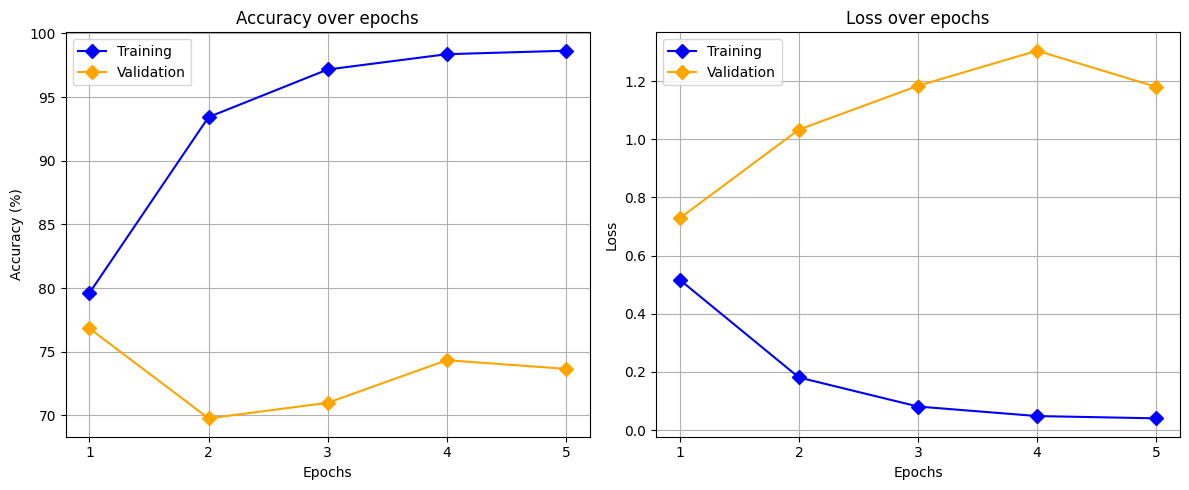

In [75]:
fig = training_validation_plot(train_acc_ls, train_loss_ls, val_acc_ls[:-1], val_loss_ls[:-1], together=True)
fig.savefig("drive/MyDrive/saved_models/ast_plot.pdf")
fig.show()

### EVALUATE AST

In [23]:
model = torch.load("drive/MyDrive/saved_models/ast_deepship_epoch_1.pth")  # Load the full fine-tuned model
model.to(DEVICE)
model.eval()


loss_fn = torch.nn.CrossEntropyLoss()
test_acc, test_loss = evaluate(model, loss_fn, test_dataloader)

<ipython-input-23-636fc580e7ea>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("drive/MyDrive/saved_models/ast_deepship_epoch_1.pth")  # Load the full f

[Validation] Accuracy: 68.880%, Loss: 0.945
